In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.distributions import Categorical

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mnist=pd.read_csv("/content/drive/MyDrive/mnist_784_csv.csv")

# PCA
To find basis of the dataset

In [ ]:
mnist_img=mnist.iloc[:,0:784]
mnist_label=mnist.iloc[:,-1]

In [ ]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(mnist_img)
print(standardized_data.shape)

(70000, 784)


In [ ]:
pca=PCA(n_components=784)

pca_data = pca.fit(mnist_img.to_numpy())
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

In [ ]:
pc_scores = pca.transform(mnist_img.to_numpy())

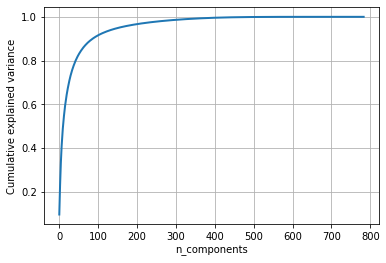

In [ ]:
# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis()
plt.grid()
plt.xlabel("n_components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
scaler = StandardScaler()
scaler.fit(mnist_img)
mnist_img = scaler.transform(mnist_img)

In [ ]:
pca = PCA(.85)
pca.fit(mnist_img)
pca.n_components_

186

In [ ]:
mnist_img = pca.transform(mnist_img)
mnist_pca=pd.concat([pd.DataFrame(mnist_img),mnist_label],axis=1)

In [ ]:
train,test=train_test_split(mnist_pca,test_size=1/7.0)

In [ ]:
# Dataloader class

from torch.utils.data import Dataset

class Mnist(Dataset):
    def __init__(self,data):
        self.data=data.values
  
    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        x=self.data[idx,0:186]
        y=self.data[idx,-1]
        return x,y

# Defence model (logistic regression)

In [ ]:
train_data=Mnist(train)
test_data=Mnist(test)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=100, shuffle=True)

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [ ]:
batch_size = 100
n_iters = 300
epochs = n_iters / (len(train_loader) / batch_size)
input_dim = 186
output_dim = 10
lr_rate = 0.001

model = LogisticRegression(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

In [ ]:
iter = 0
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = Variable(images)
                outputs = model(images.float())
                _, predicted = torch.max(outputs.data, 1)
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            print("Iteration: {}. Loss: {}. Accuracy: {}.".format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.9473192095756531. Accuracy: 72.62000274658203.
Iteration: 1000. Loss: 0.7625705599784851. Accuracy: 80.04000091552734.
Iteration: 1500. Loss: 0.6364805698394775. Accuracy: 83.66000366210938.
Iteration: 2000. Loss: 0.5075784921646118. Accuracy: 85.41000366210938.
Iteration: 2500. Loss: 0.509493350982666. Accuracy: 86.36000061035156.
Iteration: 3000. Loss: 0.48780199885368347. Accuracy: 86.91999816894531.
Iteration: 3500. Loss: 0.34575626254081726. Accuracy: 87.25.
Iteration: 4000. Loss: 0.33933231234550476. Accuracy: 87.48999786376953.
Iteration: 4500. Loss: 0.5805730819702148. Accuracy: 87.83000183105469.
Iteration: 5000. Loss: 0.31133803725242615. Accuracy: 88.0999984741211.
Iteration: 5500. Loss: 0.4012317657470703. Accuracy: 88.27999877929688.
Iteration: 6000. Loss: 0.3541508615016937. Accuracy: 88.41999816894531.
Iteration: 6500. Loss: 0.38145843148231506. Accuracy: 88.55999755859375.
Iteration: 7000. Loss: 0.37756529450416565. Accuracy: 88.70999908447266.
I

In [ ]:
torch.save(model.state_dict(),"/content/drive/MyDrive/mnist.pt")

In [ ]:
X=torch.tensor(mnist_img).float()
Y=model(X)

# Attack model

In [ ]:
#basis of X (MNIST after PCA)
Q_0,_=np.linalg.qr(X.T)

In [ ]:
Q_0=torch.tensor(Q_0.T)
Q_0.shape

torch.Size([186, 186])

In [ ]:
#Trainables (maximize wrt A, minimize wrt w and b)

A=np.random.dirichlet(np.ones(186),10000)
A=torch.tensor(A,requires_grad=True)

attack_model=nn.Linear(186,10)
[w,b]=attack_model.parameters()

In [ ]:
def forward(A,X):
  res=attack_model(torch.mm(A.float(),X))
  res=torch.exp(res)
  return res/res.sum(-1,keepdim=True)

In [ ]:
loss=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.NAdam([A,w,b],lr=0.01)

In [ ]:
def reg(w):
  norms=[torch.linalg.norm(a) for a in w]
  return sum(norms)

In [ ]:
# Attack loop
loss_list=[]
t=0
for epoch in range(500):
    t+=1
    A_ = torch.exp(A)
    B = A_ / A_.sum(-1, keepdim=True) # normalize rows manually
    y_pred=forward(B,Q_0)
    y = model(torch.mm(B.float(), Q_0))
    l=loss(y,y_pred)+(0.2/np.sqrt(t))*(Categorical(probs = B).entropy()).mean()+0.02*(reg(w)+reg(b))
    loss_list.append(l)
    l.backward()
    A.grad.data=-A.grad.data
    optimizer.step()
    optimizer.zero_grad()
    if epoch%10==0:
        print("Loss",l.data,"\n")

Loss tensor(3.4783, dtype=torch.float64) 

Loss tensor(2.6366, dtype=torch.float64) 

Loss tensor(2.5454, dtype=torch.float64) 

Loss tensor(2.5049, dtype=torch.float64) 

Loss tensor(2.4801, dtype=torch.float64) 

Loss tensor(2.4632, dtype=torch.float64) 

Loss tensor(2.4503, dtype=torch.float64) 

Loss tensor(2.4400, dtype=torch.float64) 

Loss tensor(2.4325, dtype=torch.float64) 

Loss tensor(2.4244, dtype=torch.float64) 

Loss tensor(2.4170, dtype=torch.float64) 

Loss tensor(2.4108, dtype=torch.float64) 

Loss tensor(2.4045, dtype=torch.float64) 

Loss tensor(2.3962, dtype=torch.float64) 

Loss tensor(2.3887, dtype=torch.float64) 

Loss tensor(2.3806, dtype=torch.float64) 

Loss tensor(2.3727, dtype=torch.float64) 

Loss tensor(2.3650, dtype=torch.float64) 

Loss tensor(2.3581, dtype=torch.float64) 

Loss tensor(2.3521, dtype=torch.float64) 

Loss tensor(2.3460, dtype=torch.float64) 

Loss tensor(2.3413, dtype=torch.float64) 

Loss tensor(2.3399, dtype=torch.float64) 

Loss tensor

In [ ]:
plt.plot(loss_list)